In [22]:
import sys
#!{sys.executable} -m pip install scikit-beam
#!{sys.executable} -m pip install numba
#!{sys.executable} -m pip install pandas

import functions # angular integration functions etc
import xpcs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
from scipy.optimize import curve_fit as fit
from scipy import signal
from scipy.fftpack import fft2, fftshift

#!{sys.executable} -m pip install lmfit
#!{sys.executable} -m pip install jscatter
from jscatter.formel import schulzDistribution
from jscatter.formel import pDA
from jscatter.formfactor import sphere

from dls_data_extraction import*
from integrators import *

import time
date = time.strftime("%Y-%m-%d")
datadir = './tmp/'+date+'/' # define path for saving data

In [23]:
# experimental parameters
downsample=1
distance = 4.0 # m
photon_energy = 10.0e3 # eV
h = 4.135667696e-15 # eV*s
c = 2.99792458e8 # m/s
wavelength = h*c / photon_energy # m
pix = 55e-6 # m
center_x, center_y = 1069.5//downsample, 201.5//downsample
center = center_y, center_x 

# Sample - NP in water

In [24]:
sample = '100NP_water'
scans = 252
exp_time = 1
downsample = 1
center_x, center_y = 1069.5, 201.5 # original
rois = [(0//downsample, 250//downsample)] # single ring 1x1 binning

roi_img = xpcs.make_roi(center_x, center_y, rois, downsample)
frames = xpcs.make_frames('/data/visitors/nanomax/20210623/2021052608/raw/sample/tristan-%04d*' %scans, 
                     exp_time, roi_img, downsample)
img = xpcs.make_img(frames[0])/exp_time # ph/s  
print('done')

done


## Q-map

In [25]:
# make grid
x = np.arange(0,img.shape[1])
y = np.arange(0,img.shape[0])
xx,yy = np.meshgrid(x,y)
r = (((xx-center_x)**2 + (yy-center_y)**2 ) ** 0.5)
rs = r*pix
tth = np.arctan2(rs, distance)
Q = 4.0e-9 * np.pi / wavelength * np.sin(0.5*tth) # 1/nm
Q.shape

(515, 2069)

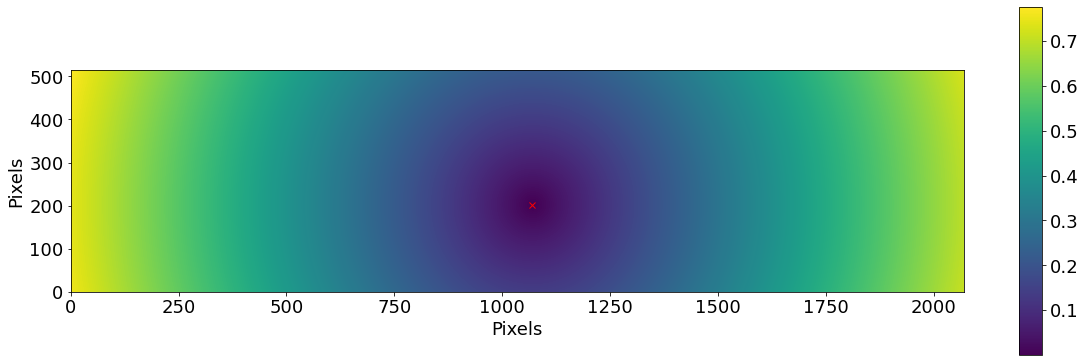

In [26]:
# Q-map
plt.figure(figsize=(20,8))
plt.imshow(Q, origin='lower') # 
plt.plot(center_x,center_y,'rx')
plt.xlabel('Pixels', size=18)
plt.ylabel('Pixels', size=18)
plt.tick_params(labelsize=18)
cbar = plt.colorbar(**dict(pad=0.05, shrink=0.8, aspect=15))
cbar.ax.tick_params(labelsize=18)
plt.xlim([0,2069//downsample])
plt.ylim([0,515//downsample])
plt.show()

# Experimental data

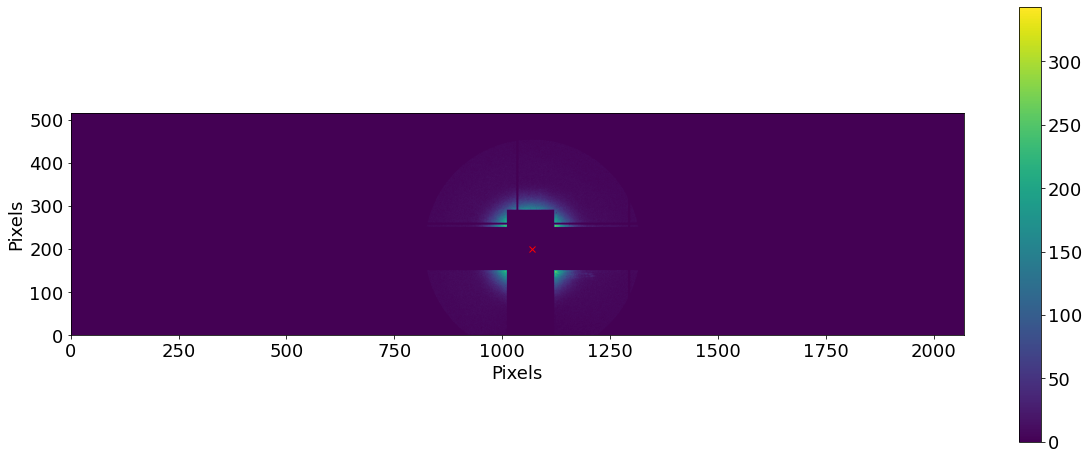

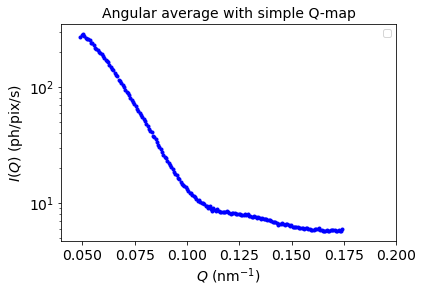

In [27]:
plt.figure(figsize=(20,8))
plt.imshow(img, origin='lower')
plt.plot(center_x,center_y,'rx')
cbar = plt.colorbar()
plt.xlabel('Pixels', size=18)
plt.ylabel('Pixels', size=18)
plt.tick_params(labelsize=18)
cbar.ax.tick_params(labelsize=18)
plt.xlim([0,2069//downsample])
plt.ylim([0,515//downsample])

Q_av, I_exp = functions.calc_Iq(Q, img, roi_img, downsample, nbins=200, n_max=250, n_min=center_y, threshold=0) # experimental

plt.figure()
plt.plot(Q_av[1:],I_exp[1:],'b.')
plt.ylabel(r'$I(Q)$ (ph/pix/s)', size=14)
plt.xlabel(r'$Q$ $\rm(nm^{-1})$', size=14)
plt.title('Angular average with simple Q-map',size=14)
plt.legend()
plt.tick_params(labelsize=14)
plt.xlim([0.04,0.2])
plt.yscale('log')

plt.show()

# Model beam

beam size at detector: 4.8 mm


/tmp/ipykernel_603/2146850198.py:30: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  smallx1 = np.int((center_x-60)/downsample)
/tmp/ipykernel_603/2146850198.py:31: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy

[0.65823529 0.65823529]


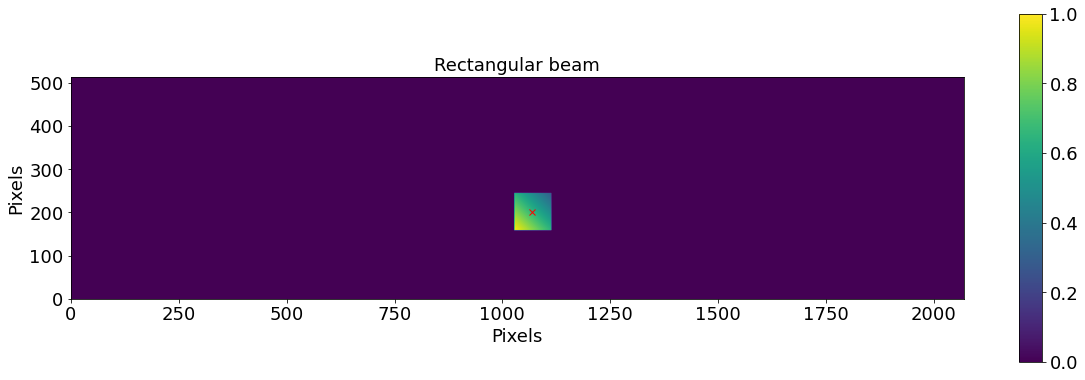

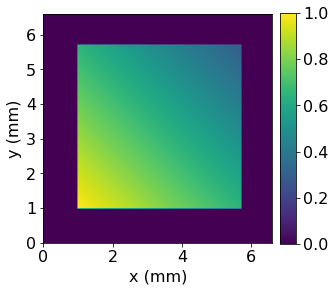

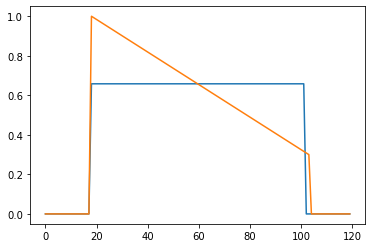

In [28]:
# beam divergence
divergence = 1.2e-3 # divergence, rad
s1 = 88e-9 # focus size, m
s2 = np.tan(divergence/2) * 2 * distance +s1 # beam size (fwhm) on detector, m
#s2 = divergence*distance # negligible difference to above
print('beam size at detector:',np.round(s2*1e3,1),'mm')

# realistic beam profile
N = s2/pix
M1,M2 = 515, 2069
ii, jj = np.indices((M1,M2))
rect_beam = ((N-ii) + (N-jj)).astype(float)
inside = (np.abs(ii-center_y) < N//2) & (np.abs(jj-center_x) < N//2)
rect_beam[~inside] = 0
rect_beam[inside] -= rect_beam[inside].min() 
rect_beam[inside] *= .7/rect_beam[inside].max() 
rect_beam[inside] += 0.3

plt.figure(figsize=(20,8))
plt.imshow(rect_beam, origin='lower') # 
plt.plot(center_x,center_y,'rx')
plt.xlabel('Pixels', size=18)
plt.ylabel('Pixels', size=18)
plt.tick_params(labelsize=18)
cbar = plt.colorbar(**dict(pad=0.05, shrink=0.8, aspect=15))
cbar.ax.tick_params(labelsize=18)
plt.title('Rectangular beam', size=18)

# figure for paper
smallx1 = np.int((center_x-60)/downsample)
smallx2 = np.int((center_x+60)/downsample)
smally1 = np.int((center_y-60)/downsample)
smally2 = np.int((center_y+60)/downsample)
small_beam = rect_beam[smally1:smally2,smallx1:smallx2]
plt.figure(figsize=(5,5))
plt.imshow(small_beam, extent=[0, pix*120*1e3, 0, pix*120*1e3], origin='lower') # 
plt.xlabel('x (mm)', size=16)
plt.ylabel('y (mm)', size=16)
plt.tick_params(labelsize=16)
cbar = plt.colorbar(**dict(pad=0.03, shrink=0.85, aspect=15))
cbar.ax.tick_params(labelsize=16)
plt.savefig('beam.png', dpi=300, bbox_inches='tight',) # save plot

rect_beam = rect_beam/np.sum(rect_beam) # normalize

# display transverse cuts
plt.figure()
diag_beam = np.flipud(small_beam).diagonal()
diag_beam2 = small_beam.diagonal()
plt.plot(diag_beam)
plt.plot(diag_beam2)

print(diag_beam[diag_beam!=0][[0,-1]])

### Image of the real beam

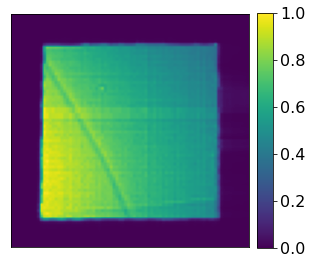

2.65900858


In [29]:
realbeam = np.load('empty_beam_3.51m_12.4keV.npz')
print(realbeam)

fig, ax = plt.subplots(figsize=(5.2,5.2))
plt.imshow(realbeam['arr_0'][760:840,1365:1447]/realbeam['arr_0'][760:840,1365:1447].max(), origin='lower')
cbar = plt.colorbar(**dict(pad=0.03, shrink=0.83, aspect=15))
cbar.ax.tick_params(labelsize=16)
plt.tick_params(color='none')
ax.set_xticklabels('')
ax.set_yticklabels('')
plt.clim([0,1])
#plt.savefig('realbeam', dpi=300, bbox_inches='tight')
plt.show()

print(realbeam['arr_0'][760:840,1365:1447].max()/1e8)

# Model form factor and convolution

In [30]:
def model_form_factor(R, sigma):
    " Computes the spherical form factor intensity for radius R and distribution standard deviation sigma "
    ff = np.empty((y[-1]+1,x[-1]+1))
    for i in range(0,y[-1]):
        ff[i,:] = pDA(sphere, R*sigma, 'radius', type='Schulz', q=Q[i,:], radius=R).Y # 1D intensity based on the particle form factor
        #sp = sphere(Q[i,:], R) # uncomment for without size distribution
        #ff[i,:] = sp.Y # uncomment for without size distribution
    ff_norm = ff/np.sum(ff) # normalize 
    return ff_norm

def convolve_with_beam(img, beam):
    " Convolve 2d model intensity with 2d beam intensity "
    img_conv = signal.convolve(img, beam, mode='same')/np.sum(beam) 
    m = np.where(img_conv == img_conv.max()) # find the new center (i.e. the maximum)
    img_conv_shift = functions.shift_image(img_conv, np.int(center_x-m[1][0]),np.int(center_y-m[0][0])) # re-center image to the beam center
    print(m)
    return img_conv_shift, m

## Fit model form factor to experimental SAXS intensity (use only to create a new fit)

### Load saved fit parameters for model form factor

In [31]:
amplitude = np.load('Iq_fit_model_amplitude.npy')
background = np.load('Iq_fit_model_background.npy')
R = np.load('Iq_fit_model_R.npy')
sigma = np.load('Iq_fit_model_sigma.npy')

print('R (nm):', R)
print('sigma (%):', sigma*100)
print('amplitude:', amplitude, 'background:', background)

R (nm): 48.333594583447606
sigma (%): 8.441281501241866
amplitude: 12116087.634287596 background: 4.426309812407543


# Convoluted model intensity

(515, 2069)


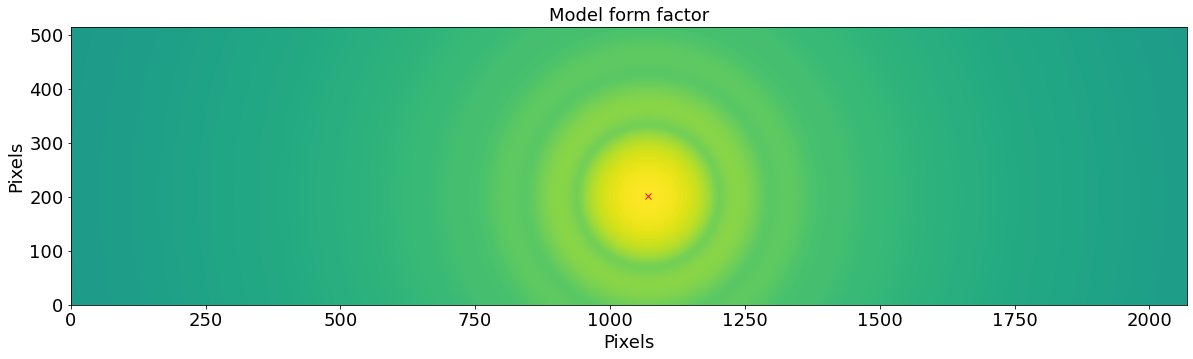

In [32]:
I0 = model_form_factor(R,sigma) # model intensity without convolution
print(I0.shape)

plt.figure(figsize=(20,8))
plt.imshow(I0, origin='lower', norm=matplotlib.colors.LogNorm()) 
plt.plot(center_x,center_y,'rx')
plt.xlabel('Pixels', size=18)
plt.ylabel('Pixels', size=18)
plt.tick_params(labelsize=18)
plt.xlim([0,2069//downsample])
plt.ylim([0,515//downsample])
plt.title('Model form factor', size=18)
plt.show()

/tmp/ipykernel_603/267215805.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  img_conv_shift = functions.shift_image(img_conv, np.int(center_x-m[1][0]),np.int(center_y-m[0][0])) # re-center image to the beam center


(array([141]), array([1100]))


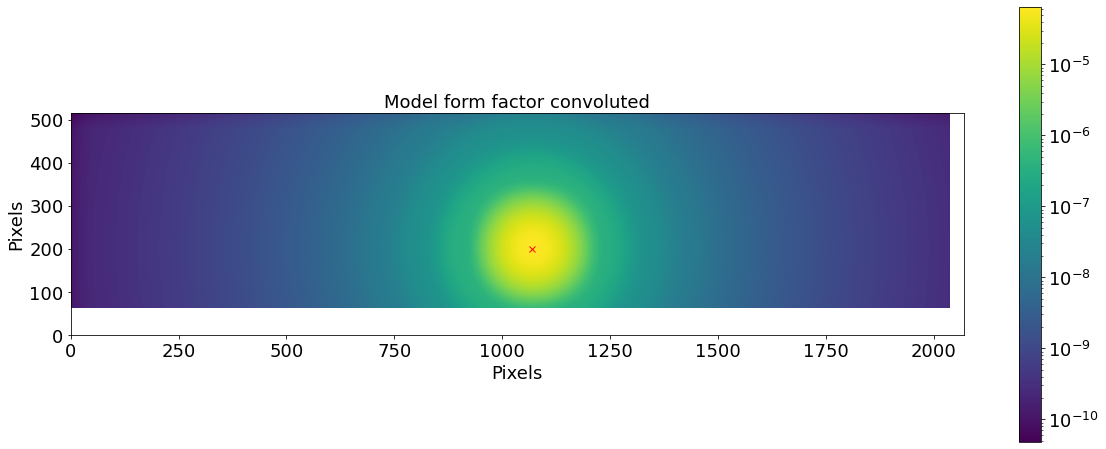

In [33]:
smallx1 = np.int64((center_x-250)/downsample)
smallx2 = np.int64((center_x+250)/downsample)
smally1 = np.int64((center_y-140)/downsample)
smally2 = np.int64((center_y+250)/downsample)

I, m = convolve_with_beam(I0,rect_beam) # model intensity with convolution

plt.figure(figsize=(20,8))
plt.imshow(I, origin='lower', norm=matplotlib.colors.LogNorm()) 
plt.plot(center_x,center_y,'rx')
cbar = plt.colorbar()
plt.xlabel('Pixels', size=18)
plt.ylabel('Pixels', size=18)
plt.tick_params(labelsize=18)
cbar.ax.tick_params(labelsize=18)
plt.xlim([0,2069//downsample])
plt.ylim([0,515//downsample])
plt.title('Model form factor convoluted', size=18)
plt.show()

# Angular integration

/mxn/visitors/sharonb/jupyter_notebooks/functions.py:50: RuntimeWarning: Mean of empty slice.
  Q_av = np.array([Q_map_flat[inds == i].mean() for i in range(0, nbins+1)])
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/mxn/visitors/sharonb/jupyter_notebooks/functions.py:51: RuntimeWarning: Mean of empty slice.
  I_av = np.array([I_map_flat[inds == i].mean() for i in range(0, nbins+1)])


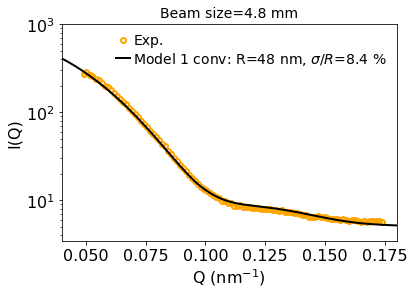

In [34]:
from lmfit.models import Model
def normalize(x, amplitude, background): 
    return np.log10(amplitude * x + background)
model = Model(normalize) 
pars = model.make_params()
pars['amplitude'].set(1e3, min=0)
pars['background'].set(4, min=0, max=100)

# model intensity without convolution
Q_av_m, I_model0 = functions.calc_Iq(Q, I0, None, downsample, nbins=200, n_max=250, n_min=140, threshold=0) # model without convolution
scale_model0 = model.fit(np.log10(I_exp[1:]), params=pars, x=I_model0[1:]) # fit amplitude and background to experimental data

# model intensity with convolution
Q_av_m, I_model = functions.calc_Iq(Q, I, None, downsample, nbins=400, n_max=400, n_min=140, threshold=0) # convoluted model, larger Q-range
Q_av_m, I_model0 = functions.calc_Iq(Q, I0, None, downsample, nbins=400, n_max=400, n_min=140, threshold=0) # model without convolution

# experimental intensity
Q_av, I_exp = functions.calc_Iq(Q, img, roi_img, downsample, nbins=200, n_max=250, n_min=center_y, threshold=0) # experimental

###############################################################
# fitted amplitude and background to match the experimental data:
###############################################################

# plot and compare I(q) with convolution and experimental intensity:
plt.figure()
plt.plot(Q_av[1::2],I_exp[1::2],'o', ms=5, markeredgecolor='orange', markerfacecolor='none', markeredgewidth=2, label='Exp.')
plt.plot(Q_av_m[1:], I_model[1:]*amplitude + background,'k-', lw=2, label='Model 1 conv: R=%.d nm, $\sigma/R$=%.1f %%' %(R, sigma*100))

plt.xlabel('Q (nm$^{-1}$)',size=16)
plt.ylabel('I(Q)',size=16)
plt.yscale('log')
plt.title('Beam size=%.1f mm' %(s2*1e3),size=14)
plt.tick_params(labelsize=16)
plt.legend(loc='upper right', frameon=False, prop={'size': 14}, labelspacing=0.2, handletextpad=0.2, handlelength=1.0, borderpad=0.2)
plt.xlim([0.04,0.18])

#plt.savefig('Iq_conv_'+str(scans)+'.png', dpi=300, bbox_inches='tight',) # save plot

plt.show()

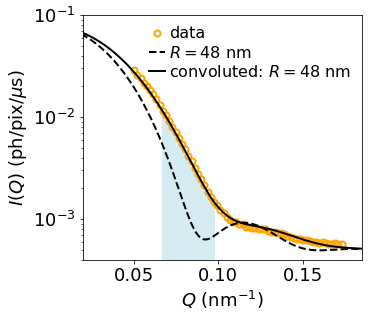

In [35]:
# plot I(q) for paper

unit = 1e6 
binning = 10*10

# display the results
fig = plt.figure(figsize=[5,4.5])

plt.plot(Q_av[::3], I_exp[::3]/exp_time/unit*binning, 'o', ms=6, markeredgecolor='orange', markerfacecolor='none', markeredgewidth=2, label='data')
plt.plot(Q_av_m[1:],(I_model0[1:]*amplitude*0.75  + background)/unit*binning, 'k--', lw=2, label=r'$R = %.d$ nm' %(R))
plt.plot(Q_av_m[1:],(I_model[1:]*amplitude + background)/unit*binning, 'k-', lw=2, label=r'convoluted: $R = %.d$ nm' %(R))

indlim=np.argwhere((Q_av>0.0664) & (Q_av<0.099))
plt.fill_between(Q_av[indlim[0][0]:indlim[-1][0]], I_exp[indlim[0][0]:indlim[-1][0]]/exp_time/unit*binning, facecolor='lightblue', alpha=0.5)

plt.ylabel('$I(Q)$ (ph/pix/$\mu$s)',size=18) # per 10x10 superpixel
plt.xlabel('$Q$ (nm$^{-1}$)',size=18)
plt.tick_params(labelsize=18)
plt.legend(loc='upper right', frameon=False, prop={'size': 16}, labelspacing=0.2, handletextpad=0.2, handlelength=1.0, borderpad=0.2);
plt.yscale('log')
plt.xlim([2e-2,18.5e-2])
plt.ylim([4e-4, 10e-2]) 

#plt.savefig('Iq_'+sample+'_'+str(scans)+'_'+str(downsample)+'x'+str(downsample)+'_'+str(exp_time)+'s.png', dpi=300, bbox_inches='tight',) # save plot

plt.show()

# Dynamic analysis

In [36]:
# choose solvent and temperature of interest:
solvent = 'water'
T = 295 # K

In [37]:
def make_decay_rate_map(Rh):
    " Create a decay rate map for a Q-map of interest based on the diffusion coefficient D from Stokes-Einstein relation and the hydrodynamic radius Rh "
    D = k*T/(6*np.pi*Rh*1e-9*viscosity) # SE diffusion coefficient
    return D*(Q*1e9)**2 # decay rate map
    
def calc_D(Rh):    
    " Calculate the Stokes-Einstein diffusion coefficient D from the hydrodynamic radius Rh "
    D = k*T/(6*np.pi*Rh*1e-9*viscosity)  # SE diffusion coefficient
    return D 


from scipy.interpolate import interp1d

def model_func_xpcs(x, Rh): 
    " Convolute the 2d model dynamics map `x` with the divergent 2d beam, weighted by the 2d model intensity, for particle with hydrodynamic radius Rh. "
    " Choose method to convolute (model 1) x=decay rates (model 2) x=relaxation times (model 3) x=Q. "
    if model==1:
        Gamma0 = make_decay_rate_map(Rh)
        X_conv = signal.convolve(Gamma0*I0, rect_beam, mode='same')/np.sum(rect_beam)  # convolute the decay rates, Gamma0*I0
    elif model==2:
        Gamma0 = make_decay_rate_map(Rh)
        X_conv = signal.convolve(1/Gamma0*I0, rect_beam, mode='same')/np.sum(rect_beam) # convolute the relaxation times, tau0*I0
    elif model==3:
        D = calc_D(Rh)
        X_conv = signal.convolve(Q*I0, rect_beam, mode='same')/np.sum(rect_beam) # convolute the Q-map, Q*I0
        
    X_conv_shifted = functions.shift_image(X_conv, np.int64(center_x-m[1][0]), np.int64(center_y-m[0][0]))/I # shift and normalize by I
    Q_av, Xconv_av = functions.calc_Iq(Q, X_conv_shifted, roi_img, downsample, nbins=110, n_max=110, n_min=140, threshold=0) # n_min=140 due to shift, to avoid the lower zero rows
    
    if model==1:
        tau_interp = interp1d(Q_av[1:], 1/Xconv_av[1:]*1e6, kind='cubic') # calculate tau for fit
    elif model==2:
        tau_interp = interp1d(Q_av[1:], Xconv_av[1:]*1e6, kind='cubic')
    elif model==3:
        Qconv_av = Xconv_av*1e9 # 1/nm to 1/m
        tau_interp = interp1d(Q_av[1:], 1/(D*Qconv_av[1:]**2)*1e6, kind='cubic') # calculate tau for fit
        
    return tau_interp(x)


## Fit relaxation times

In [38]:
model = 2 # choose model (model=2 for paper)

# load bulk viscosities for the solvents (from literature):
ndata_w1 = np.loadtxt('./viscositydata_dehaoui.dat', delimiter=',') # water viscosity
ndata_w2=np.loadtxt('./macroscopic_viscosity_water_hallet_kestin_collings.dat',delimiter=',') # more water viscosity
ndata_w=np.vstack((ndata_w1,ndata_w2))
n_dmso = np.array([339.6, 214.7, 140.2, 43.47, 18.25, 14.27, 9.16, 6.17, 5.18, 4.383])*1e-3 # 33 mol% dmso-water viscosity, schichman & Amey, JPC 1971
T_dmso = np.array([-55, -50, -45, -30, -15, -10, 0, 10, 15, 20])+273.15
popt_w, pcov_w= fit(power_law,ndata_w[:,0],ndata_w[:,1]*1e-3,p0=[1e-4,220,2]) # fit power law to water viscosity
popt_dmso_power, pcov_dmso_power = fit(power_law,T_dmso[6:],n_dmso[6:], p0=[1e-4,200,3]) # fit power law to dmso-water viscosity

# load experimental xpcs data (relaxation times tau) and fit to the convoluted model:
if solvent=='water':
    tau_data_exp = np.load('tau_data_water_simple_exp.npy')
    Rh_all, Rh_err_all = fit(model_func_xpcs, tau_data_exp[0,:], tau_data_exp[1,:], sigma=tau_data_exp[2,:], p0=[50])
    print('Fitted Rh (nm):',Rh_all, Rh_err_all) # hydrodynamic radius, nm
    viscosity=power_law(T,*popt_w)
elif solvent=='dmso':
    tau_data_exp = np.load('tau_data_dmso_simple_exp.npy')
    Rh_all = np.empty((3,))
    Rh_err_all = np.empty((3,))
    for i in range(3):
        Rh_all[i], Rh_err_all[i] = fit(model_func_xpcs, tau_data_exp[0,:,i], tau_data_exp[1,:,i], sigma=tau_data_exp[2,:,i], p0=[60])
    print('Fitted Rh (nm):', Rh_all, Rh_err_all) # hydrodynamic radius, nm
    viscosity = power_law(T, *popt_dmso_power)

k=1.38064852e-23 # boltzmann constant, J/K
D = k*T/(6*np.pi*Rh_all*1e-9*viscosity) # diffusion coefficient, m^2/s
Derr = k*T/(6*np.pi*viscosity)*1/(Rh_all*1e-9)**2*Rh_err_all*1e-9
print('Fitted D (m^2/s):', D, Derr)

/tmp/ipykernel_603/3862273765.py:27: RuntimeWarning: invalid value encountered in true_divide
  X_conv_shifted = functions.shift_image(X_conv, np.int64(center_x-m[1][0]), np.int64(center_y-m[0][0]))/I # shift and normalize by I


Fitted Rh (nm): [62.45281499] [[0.18438924]]
Fitted D (m^2/s): [3.61533585e-12] [[1.06741233e-14]]


### Map of the dynamic quantity X

In [39]:
i = 0 # choose which result from above to display (if more than one, otherwise i=0)
save = False # to save the fit results
Rh = Rh_all[i]
print('Fitted Rh (nm):', Rh)
if model==1:
    X0 = make_decay_rate_map(Rh)
if model==2:
    X0 = 1/make_decay_rate_map(Rh)
elif model==3:
    D = calc_D(Rh)
    X0 = Q

Fitted Rh (nm): 62.45281499202085


### Display the 2d maps used in the fitting

/tmp/ipykernel_603/3362172239.py:35: RuntimeWarning: invalid value encountered in true_divide
  Xconv_shifted = functions.shift_image(X_conv, np.int64(center_x-m[1][0]), np.int64(center_y-m[0][0]))/I


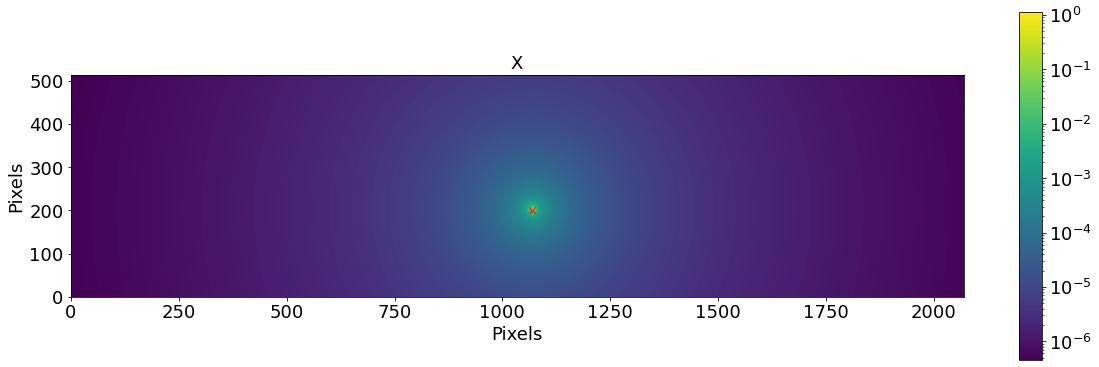

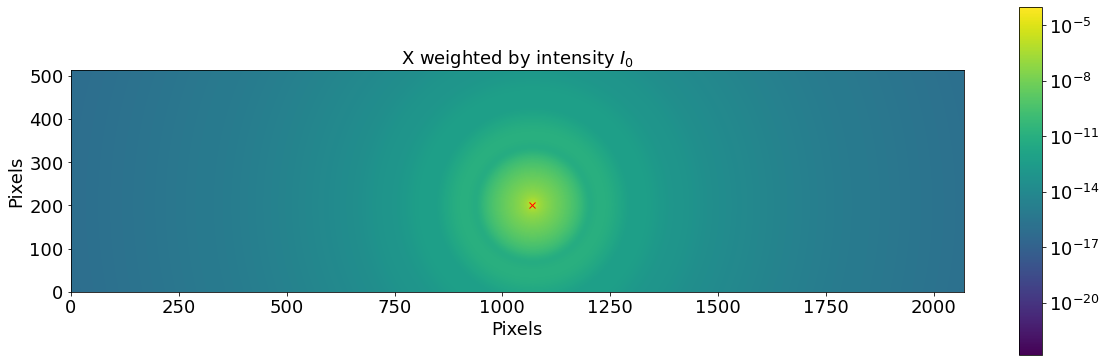

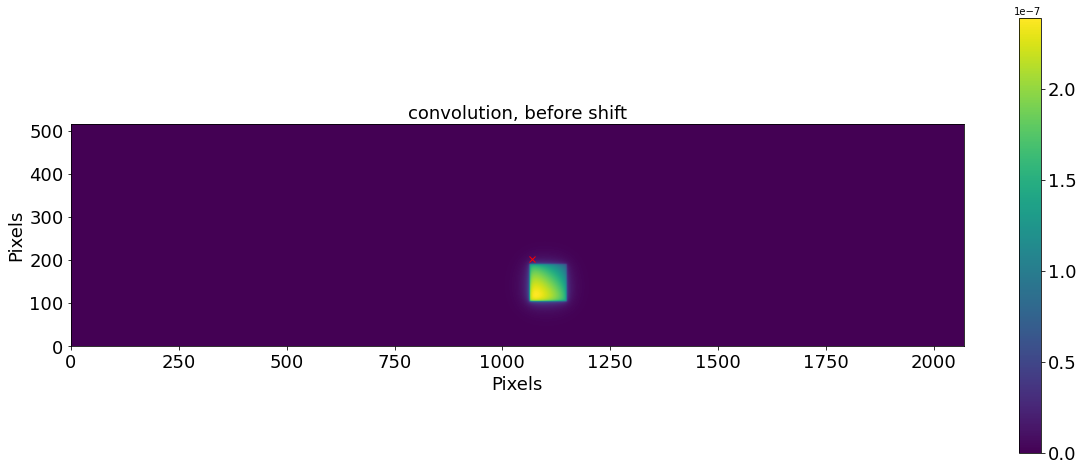

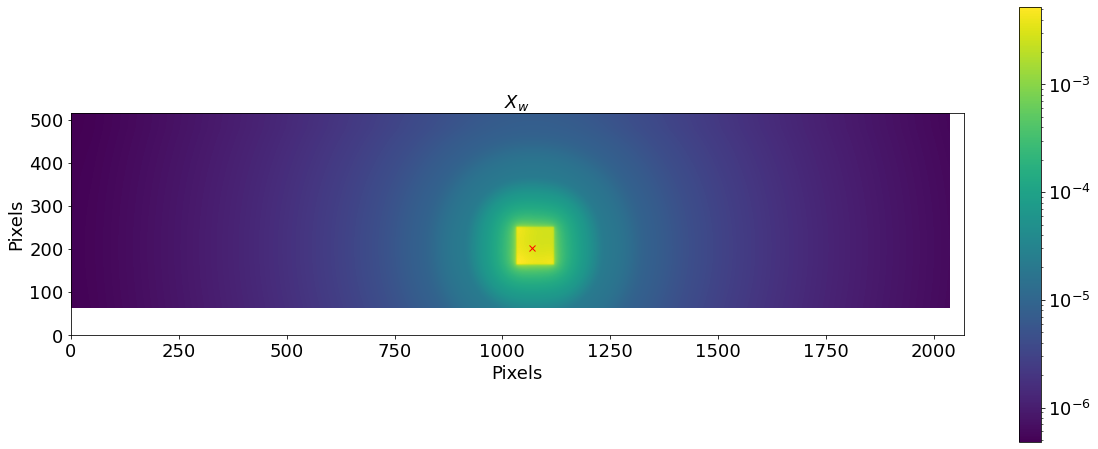

In [40]:
plt.figure(figsize=(20,8))
plt.imshow(X0, origin='lower', norm=matplotlib.colors.LogNorm()) # 
plt.plot(center_x,center_y,'rx')
plt.xlabel('Pixels', size=18)
plt.ylabel('Pixels', size=18)
plt.tick_params(labelsize=18)
cbar = plt.colorbar(**dict(pad=0.05, shrink=0.8, aspect=15))
cbar.ax.tick_params(labelsize=18)
plt.title(r'X', size=18)

plt.figure(figsize=(20,8))
plt.imshow(X0*I0, origin='lower', norm=matplotlib.colors.LogNorm()) # 
plt.plot(center_x,center_y,'rx')
plt.xlabel('Pixels', size=18)
plt.ylabel('Pixels', size=18)
plt.tick_params(labelsize=18)
cbar = plt.colorbar(**dict(pad=0.05, shrink=0.8, aspect=15))
cbar.ax.tick_params(labelsize=18)
plt.title(r'X weighted by intensity $I_0$', size=18)

# convolve with the model beam: 
X_conv = signal.convolve(X0*I0, rect_beam, mode='same')/np.sum(rect_beam)

plt.figure(figsize=(20,8))
plt.imshow(X_conv, origin='lower') 
plt.plot(center_x,center_y,'rx')
cbar = plt.colorbar()
plt.xlabel('Pixels', size=18)
plt.ylabel('Pixels', size=18)
plt.tick_params(labelsize=18)
cbar.ax.tick_params(labelsize=18)
plt.title(r'convolution, before shift', size=18) 

# shift and divide by conv convolved model I0 (i.e. I) to retrieve the convolved intensity-weighted X:
Xconv_shifted = functions.shift_image(X_conv, np.int64(center_x-m[1][0]), np.int64(center_y-m[0][0]))/I

plt.figure(figsize=(20,8))
plt.imshow(Xconv_shifted, origin='lower', norm=matplotlib.colors.LogNorm()) 
plt.plot(center_x,center_y,'rx')
cbar = plt.colorbar()
plt.xlabel('Pixels', size=18)
plt.ylabel('Pixels', size=18)
plt.tick_params(labelsize=18)
cbar.ax.tick_params(labelsize=18)
plt.title(r'$X_w$', size=18) 

plt.show()

### Angular integration of the convolved dynamic quantity X

[[6.42780862e-02 6.68874527e-02 7.11154105e-02 7.45149873e-02
  7.85120394e-02 8.11353356e-02 8.47516837e-02 8.83942964e-02
  9.21225682e-02 9.52566606e-02 9.88977619e-02]
 [1.47026819e+02 1.32592122e+02 1.14305456e+02 1.06943853e+02
  9.28492717e+01 8.73631331e+01 7.73511536e+01 6.97788927e+01
  6.13240545e+01 5.22974450e+01 4.49124256e+01]
 [1.02673227e+00 8.84052440e-01 7.55827777e-01 7.13036613e-01
  7.44282691e-01 7.67611345e-01 7.58425878e-01 9.16394420e-01
  1.04129404e+00 1.32166914e+00 1.37932500e+00]]
fitted Q-exponents:
normal: 2.000037113575356 conv: 2.6912800899221674
fitted D:
normal: 3.615229645997795e-12
conv: 1.75282958564035e-12
0.0643069735224743 0.09873491252558537


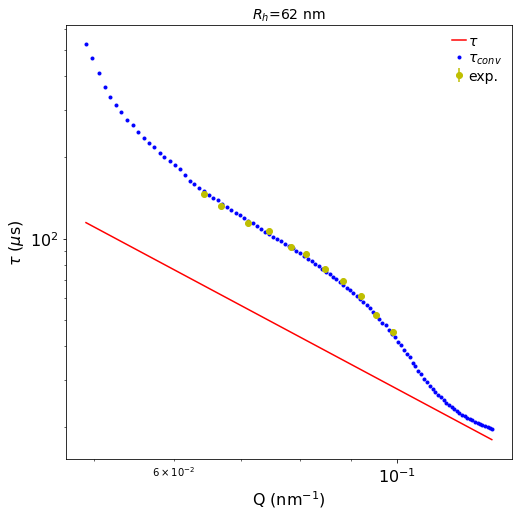

In [41]:
# angular integration of the fitted convoluted model dynamics:
if model==1:
    Q_av, Gamma0_av = functions.calc_Iq(Q, X0, roi_img, downsample, nbins=110, n_max=110, n_min=140, threshold=0) # n_min=140 due to shift, to avoid the lower zero rows
    Q_av, Gamma_av = functions.calc_Iq(Q, Xconv_shifted, roi_img, downsample, nbins=110, n_max=110, n_min=140, threshold=0) # n_min=140 due to shift, to avoid the lower zero rows
    tau0_av = 1/Gamma0_av
    tau_av = 1/Gamma_av
if model==2:
    Q_av, tau0_av = functions.calc_Iq(Q, X0, roi_img, downsample, nbins=110, n_max=110, n_min=140, threshold=0)
    Q_av, tau_av = functions.calc_Iq(Q, Xconv_shifted, roi_img, downsample, nbins=110, n_max=110, n_min=140, threshold=0)
elif model==3:
    Q_av, Qconv_av = functions.calc_Iq(Q, Xconv_shifted, roi_img, downsample, nbins=110, n_max=110, n_min=140, threshold=0)
    tau_av = 1/(D*(Qconv_av*1e9)**2)
    tau0_av = 1/(D*(Q_av*1e9)**2)

ind = np.argwhere((Q_av>0.06427809) & (Q_av<0.09889776)) # find indices in similar Q-range as the experimental data

# Q-exponent fit:
def tau_fit(x,a,b):
    return -a*x + b # q-dependence fit
popt, pcov = fit(tau_fit, np.log(Q_av[1:]), np.log(tau0_av[1:]), p0=[2,1]) 
popt_c, pcov_c = fit(tau_fit, np.log(Q_av[ind[0][0]-1:ind[-1][0]+1]), np.log(tau_av[ind[0][0]-1:ind[-1][0]+1]), p0=[2,1]) 

# Q^2 fit:
def tau_fit2(x,a):
    return (1/a)*x  
popt2, pcov2 = fit(tau_fit2, 1/(Q_av[1:]*1e9)**2, tau0_av[1:], p0=[1e-12]) 
popt_c2, pcov_c2 = fit(tau_fit2, 1/(Q_av[ind[0][0]:ind[-1][0]]*1e9)**2, tau_av[ind[0][0]:ind[-1][0]], p0=[1e-12])

# the experimental xpcs data
if solvent=='water':
    tau_data_exp = np.load('tau_data_water_simple_exp.npy')
elif solvent=='dmso':
    tau_data_exp = np.load('tau_data_dmso_simple_exp.npy')
    tau_data_exp = tau_data_exp[:,:,i]
print(tau_data_exp)

#from scipy.interpolate import interp1d
#tau_interp = interp1d(Q_av[1:], tau_av[1:], kind='cubic')
#qvals = np.linspace(Q_av[1], Q_av[-1], 100)
#tau_int = tau_interp(qvals)

# plot the angular average and compare, log Q scale
plt.figure(figsize=(8,8))
plt.plot(Q_av[1:], tau0_av[1:]*1e6,'r-', label=r'$\tau$')
plt.plot(Q_av[1:], tau_av[1:]*1e6,'b.', label=r'$\tau_{conv}$')
#plt.plot(Q_av[1:], np.exp(tau_fit(np.log(Q_av[1:]), *popt))*1e6,'g--', lw=1.5, label=r'$Q^n$-fit') 
#plt.plot(Q_av[1:], np.exp(tau_fit(np.log(Q_av[1:]), *popt_c))*1e6,'m--', lw=1.5, label=r'$Q^n$-fit') 
plt.errorbar(tau_data_exp[0,:], tau_data_exp[1,:], yerr=tau_data_exp[2,:], fmt='o', color='y', label='exp.')
plt.xlabel(r'Q (nm$^{-1}$)', size=16)
plt.ylabel(r'$\tau$ ($\mu$s)', size=16)
plt.yscale('log')
plt.xscale('log')
plt.title('$R_h$=%.d nm' %(Rh),size=14)
plt.tick_params(labelsize=16)
plt.legend(loc='best', frameon=False, prop={'size': 14}, labelspacing=0.2, handletextpad=0.2, handlelength=1.0, borderpad=0.2);

print('fitted Q-exponents:')
print('normal:',popt[0],'conv:', popt_c[0])
print('fitted D:')
print('normal:', popt2[0])
print('conv:', popt_c2[0])
print(Q_av[ind[0][0]], Q_av[ind[-1][0]])

if save == True:
    if solvent=='water':
        np.save('Q_av_tau_NPwater_simple_exp',Q_av)
        np.save('tau_av_NPwater_simple_exp',tau_av)
        np.save('tau0_av_NPwater_simple_exp',tau0_av)
    elif solvent=='dmso':
        np.save('Q_av_tau_NPdmso_'+str(i)+'_simple_exp',Q_av)
        np.save('tau_av_NPdmso_'+str(i)+'_simple_exp',tau_av)
        np.save('tau0_av_NPdmso_'+str(i)+'_simple_exp',tau0_av)
        